How to build a good number reader: https://www.youtube.com/watch?v=y1ZrOs9s2QA&t=0s

# Load & Check packages

May need to download Tensorflow 2.3.0 instead utilizing this specific build package -- https://github.com/ContinuumIO/anaconda-issues/issues/12194#issuecomment-751700156

Then get the appropriate CUDA, cuDNN, and TensorRT versions =/

1) How to set up environment 

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/install/tensorflow-install-jul-2020.ipynb

2) Versions to get

https://www.tensorflow.org/install/source_windows

3) How to set up CUDA and such

https://www.tensorflow.org/install/gpu

In [3]:
import tensorflow as tf
import numpy as np
import os

Check tensorflow environment

In [2]:
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.3.0


Check GPU availability

In [105]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE") #Check if available

GPU is available


Check the GPU name --- To double confirm that your GPU is available

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.gpu_device_name()

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16051793030981336897
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4508431093423625062
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6963698080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8601705304436765310
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:2b:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15268544499097709741
physical_device_desc: "device: XLA_GPU device"
]


'/device:GPU:0'

Enable GPU

In [5]:
try:
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Success!")
except:
    print("Could not set memory_growth")

Success!


Import packages

In [4]:
import glob
import os
import PIL
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython import display

# Load images

If the below code has issues:

Use the following update to the file located in this path:
C:\Users\Brandon\AppData\Roaming\Python\Python37\site-packages\tensorflow_datasets\d4rl\dataset_utils.py

Source: https://github.com/tensorflow/lucid/issues/201
```
#from tensorflow_io import gfile #tensorflow_io was called tensorflow.io (dot) ... but even then this "gfile" was moved and the following code below is the fix (BJT 05/11/21)
import tensorflow.compat.v1.gfile as gfile
```

In [7]:
#Download MNIST training data
import tensorflow_datasets as tfds
train_df, train_label = tfds.as_numpy(tfds.load(
    'mnist',
    split='train', 
    batch_size=-1, 
    as_supervised=True,
))

test_df, test_label = tfds.as_numpy(tfds.load(
    'mnist',
    split='test', 
    batch_size=-1, 
    as_supervised=True,
))

In [8]:
img_shape = (28,28,1)
classes = np.unique(train_label)
num_classes = len(classes)
print(classes,num_classes)

[0 1 2 3 4 5 6 7 8 9] 10


# Preprocessing

For the purpose of sudoku -- we don't need to train the model on `0` class

In [9]:
#Select entries where 0 is not the class identity

#Train
train_df = train_df[train_label!=0]
train_label = train_label[train_label!=0]


#Test
test_df = test_df[test_label!=0]
test_label = test_label[test_label!=0]

train_n = train_df.shape[0] #Num of images in train
test_n = test_df.shape[0] #Num of images in test
print(train_df.shape)
print(test_df.shape)

classes = np.unique(train_label)
num_classes = len(classes)
print(classes,num_classes)

(54077, 28, 28, 1)
(9020, 28, 28, 1)
[1 2 3 4 5 6 7 8 9] 9


Adjust the labels because everything needs to be 0-indexed

In [10]:
train_label -= 1 #Convert [1,9] to [0,8] because SparseCategoricalCrossentropy requires the one-hot encoding starts at 0
test_label -= 1 #Also need to do that for the test data

print(np.unique(train_label))
print(np.unique(test_label))

[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


# Define augmentations to images

To aid the model in interpreting photos of sudoku grids from the internet

Augment the images with noise + slight modification to rotation & zoom
- Sometimes the images may be smaller or larger numbers
- Sometimes they will be slightly imperfect (askew)
- Lastly, the noise helps where cv2 fails to always generate a perfect image after processing & refinement

In [64]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_shape[0], img_shape[1],input_shape=[28,28,1]),
])


In [65]:
data_augmentation = tf.keras.Sequential(
  [     
    layers.GaussianNoise(0.2,input_shape=[28,28,1]), #Add noise with 0.2 std-dev
#    layers.experimental.preprocessing.RandomRotation(0.2),
#    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

# Define model

In [66]:
#Model from https://www.kaggle.com/henseljahja/simple-tensorflow-cnn-98-8
model = keras.models.Sequential([
    data_augmentation,
    layers.Conv2D(filters=64, kernel_size=7),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(0.5),    
    keras.layers.Dense(units=9, activation='softmax'), #9 outputs [1,2,3,4,5,6,7,8,9]
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)        

In [67]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = 'nadam',
    metrics=['accuracy']
)

In [68]:
%%time
#epochs = 20
#result = model.fit(
#    x = train_df,
#    y = train_label,
#    validation_split=0.1,
#    batch_size=256,
#    shuffle=True,
#    epochs=epochs
#)

result = model.fit(train_df,train_label,
                   validation_split=.1,
                   epochs=20,
                   shuffle=True)

Epoch 1/20
1521/1521 [==============================] - 6s 4ms/step - loss: 0.6610 - accuracy: 0.7928 - val_loss: 0.1519 - val_accuracy: 0.9676
Epoch 2/20
1521/1521 [==============================] - 6s 4ms/step - loss: 0.2202 - accuracy: 0.9517 - val_loss: 0.1114 - val_accuracy: 0.9737
Epoch 3/20
1521/1521 [==============================] - 6s 4ms/step - loss: 0.1897 - accuracy: 0.9590 - val_loss: 0.1454 - val_accuracy: 0.9673
Epoch 4/20
1521/1521 [==============================] - 6s 4ms/step - loss: 0.1693 - accuracy: 0.9626 - val_loss: 0.0916 - val_accuracy: 0.9811
Epoch 5/20
1521/1521 [==============================] - 6s 4ms/step - loss: 0.1746 - accuracy: 0.9651 - val_loss: 0.1380 - val_accuracy: 0.9713
Epoch 6/20
1521/1521 [==============================] - 6s 4ms/step - loss: 0.1524 - accuracy: 0.9690 - val_loss: 0.1068 - val_accuracy: 0.9817
Epoch 7/20
1521/1521 [==============================] - 6s 4ms/step - loss: 0.1650 - accuracy: 0.9668 - val_loss: 0.1233 - val_accuracy:

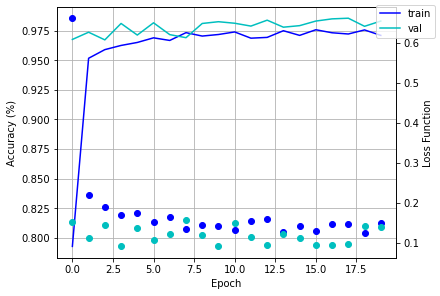

In [69]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
los = result.history['loss']
val_los = result.history['val_loss']

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(acc,'b')
ax.plot(val_acc,'c')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")

ax2 = ax.twinx()
ax2.plot(los,'bo')
ax2.plot(val_los,'co')
ax2.set_ylabel("Loss Function")

fig.tight_layout
fig.legend(['train','val']) #Dots = loss || lines = accuracy
ax.grid('on')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Model is 98.71 accuract at predicting test data


array([[1128,    1,    0,    0,    3,    0,    2,    0,    1],
       [   0, 1025,    0,    0,    0,    0,    4,    3,    0],
       [   0,    2,  988,    0,    8,    1,    5,    5,    1],
       [   0,    0,    0,  963,    0,    3,    2,    0,   14],
       [   0,    0,    3,    0,  883,    3,    1,    1,    1],
       [   3,    0,    0,    4,    1,  948,    0,    1,    1],
       [   1,    1,    0,    2,    0,    0, 1020,    0,    4],
       [   1,    1,    1,    1,    1,    2,    0,  965,    2],
       [   1,    0,    0,    4,    7,    0,    5,    8,  984]],
      dtype=int64)

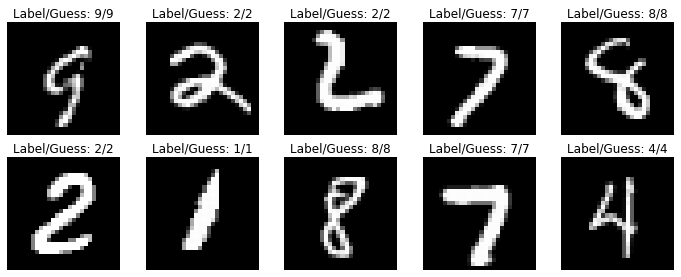

In [70]:
def accuracy(df,labels,mod):
    guess = mod.predict_classes(df)
    n = len(labels)
    correct = np.sum(guess==labels)
    
    plt.figure(figsize=(12, 12))
    for i in range(10):
        rand_int = np.random.randint(len(df)) #Pick a random number
        ax = plt.subplot(5,5,i+1)
        ax.imshow(df[rand_int],cmap='gray') #Display the data
        plt.title("Label/Guess: %s/%s"%(str(labels[rand_int]+1),str(guess[rand_int]+1))) #Show the label + guess
        ax.axis('off')
    return correct/n*100

from sklearn.metrics import confusion_matrix
test_acc = accuracy(test_df,test_label,model)
print("Model is %.2f accuract at predicting test data"%test_acc)
guess = model.predict_classes(test_df)
confusion_matrix(test_label,guess)

# Save model - the Tensorflow way

In [71]:
#model_name = 'my_model.h5' #base model 12 epoch
model_name = '2021-05-15 98_53acc Model Gauss.h5' #With 4Conv2D + dropout and 22 epochs
#model_name = 'my_model_4Conv_dropout_18ep.h5' #With 4Conv2D + dropout and 18 epochs

model.save(model_name)

# Save the weights
#model.save_weights('./checkpoints/my_checkpoint')

# Test loading of model

In [11]:
# Recreate the exact same model, including its weights and the optimizer
loaded_model = tf.keras.models.load_model(model_name)

# Show the model architecture
print(loaded_model.summary())

loss, acc = loaded_model.evaluate(test_df, test_label, verbose=2)
print('Restored model test accuracy: {:5.2f}%'.format(100 * acc))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)        

# Deep dive on a singular entry

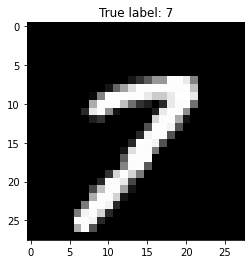

Guess: 7
Confidence: 100.00


In [12]:
randi = np.random.randint(len(test_df))
plt.imshow(test_df[randi],cmap='gray')
plt.title("True label: " + str(test_label[randi]+1))
plt.show()

pred = loaded_model.predict(np.reshape(test_df[randi],(1,28,28,1)))

num = np.argmax(pred)+1 #Plus 1 because the class labels are [0,8] while the true numbers are [1,9]
conf = np.amax(pred)

print("Guess: %s\nConfidence: %.2f"%(num,conf*100))


# Test model on images gathered from the sudoku grid

Grid layout per images loaded:


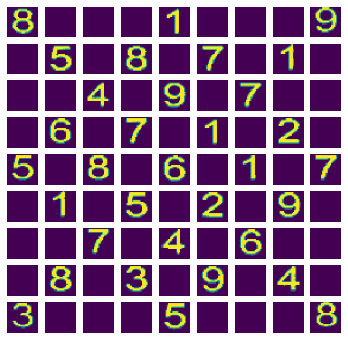

In [13]:
#Load images
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

files = []
for i in range(82):
    files.append("Test Sudoku Images/"+str(i)+".jpg")
images = [] #Blank to hold image file
label_id = [] #Blank to hold the true labels
labels = [8,0,0,0,1,0,0,0,9, #Hand code all the actual labels
         0,5,0,8,0,7,0,1,0,
         0,0,4,0,9,0,7,0,0,
         0,6,0,7,0,1,0,2,0,
         5,0,8,0,6,0,1,0,7,
         0,1,0,5,0,2,0,9,0,
         0,0,7,0,4,0,6,0,0,
         0,8,0,3,0,9,0,4,0,
         3,0,0,0,5,0,0,0,8]
for i,label in enumerate(labels):
    if label != 0:
        
        #images.append(files[i][19:]) #Remove the base directory name .. keep only "75.png" part
        img = np.asarray(Image.open(files[i])) #Read image as numpy array
        img = cv2.resize(img[48:235,160:340],(28,28)) #Resize
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = np.abs(255-img)
        
        images.append(img)
        label_id.append(label)
    else:
        images.append(np.ones((28,28))*255)

#Show images
print("Grid layout per images loaded:")
fig = plt.figure(figsize=(6,6))
for i in range(9):
    for j in range(9):
        plt.subplot(9,9,1+j+i*9)
        plt.imshow(images[j+i*9])
        plt.axis("off")
plt.show()
        
#plt.imshow(images[0],cmap='gray')
#plt.show()

#Reshape each image for processing
for i,img in enumerate(images):
    images[i] = np.reshape(img,(1,28,28,1))

In [14]:
predictions = []
grid = []
for i,img in enumerate(images):
    pred = loaded_model.predict(img)
    
    if np.max(pred) < 0.3:
        num = 0
        conf = np.amax(pred)
    else:
        num = np.argmax(pred)+1
        conf = np.amax(pred)
    grid.append(num)
    predictions.append([num,conf,labels[i]])

grid = np.array(grid)
grid = np.reshape(grid,(9,9)) #Shape as sudoku grid

#predictions
print(grid)

[[8 0 0 0 7 0 0 0 5]
 [0 5 0 8 0 7 0 7 0]
 [0 0 4 0 9 0 7 0 0]
 [0 6 0 7 0 7 0 2 0]
 [5 0 8 0 6 0 7 0 7]
 [0 7 0 5 0 2 0 0 0]
 [0 0 1 0 4 0 6 0 0]
 [0 3 0 3 0 0 0 4 0]
 [3 0 0 0 5 0 0 0 0]]


# Closing statements

This model is alright at best. It has pretty good accuracy, but the confidence level of some of the entries needs work

In [17]:
predictions[8]

[5, 0.40133232, 9]

This entry (top right corner of the grid) is predicted as a [5] with `40.13%` confidence --- It should have been a [9]!

Meanwhile there are some entries in the grid such as the bottom right entry which aren't interpreted because the confidence was below the 30% threshold I had put (which ultimately, this threshold should really be set to something like >80% confidence in my opinion because the model should be pretty definitive in its classification of the numbers!)

In [18]:
predictions[-1]

[0, 0.20665807, 8]

The bottom right entry was suppose to be [8] but the confidence was only `20.66%` and thus registered as [0]. This is nearly as bad as the model just randomly guessing (1/9 = 11.11%).

# Path forward

Sudoku books and sudoku games you find online often come with <ins>digital</ins> numbers in the grids. Ie: They're written in fonts like `Arial` or `Times New Roman` ... they aren't handwritten by humans.

Finding a dataset that is more digital would be ideal.
> Enter: E-MNIST (https://www.nist.gov/itl/products-and-services/emnist-dataset) a digital dataset of numbers and characters!